In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
import matplotlib.pyplot as plt
from bsccm import BSCCM
import numpy as onp
import time
from tqdm import tqdm
from encoding_information.bsccm_utils import *
from encoding_information.plot_utils import *
from encoding_information.bsccm_utils import *
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from matplotlib.colors import LinearSegmentedColormap
from jax import jit
import jax.numpy as np


bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-10-26 14:41:34.174391: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 14:41:34.893618: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

Opening BSCCM
Opened BSCCM


## Estimate stationary gaussian processes and draw samples from them

In [2]:
# images used to generate the covariance matrix
num_images = 10000
num_patches = 10000
edge_crop = 24

patch_size = 50 # the size of patches to estimate the covariance matrix from
sample_size = 128 - 2 * edge_crop # the size of the samples to generate
num_samples = 5


photons_per_pixel = 150

channels = ['LED119', 'DPC_Right', 'Brightfield']
# channels = ['LED119', 'DPC_Right']
# channels = ['LED119']


image_samples_gp = {}
image_samples_pcnn = {}
noisy_patches_by_channel = {}
images_by_channel = {}
noisy_images_by_channel = {}
for channel_index, channel in tqdm(enumerate(channels), desc='Loading images'):
    images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=True)
    images_by_channel[channel] = images[:num_samples * 10]
    noisy_images_by_channel[channel] = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))

for channel_index, channel in tqdm(enumerate(channels), desc='Fitting models and sampling'):
    print('getting patches')
    noisy_patches = extract_patches(noisy_images_by_channel[channel], patch_size=patch_size, num_patches=num_patches, seed=1234)
    noisy_patches_by_channel[channel] = noisy_patches[: num_samples * 10] # for display

    print('fitting stationary GP')
    gp = StationaryGaussianProcess(noisy_patches)
    _ = gp.fit(noisy_patches, verbose=True)
    cov_mat = gp.get_cov_mat()

    print('fitting PixelCNN')
    pcnn = PixelCNN()
    pcnn.fit(noisy_patches, max_epochs=25, verbose=True)

    print('generating samples for PixelCNN')
    image_samples_pcnn[channel] = pcnn.generate_samples(num_samples, sample_size, seed=channel_index * 1000, verbose=True)

    print('generating samples for stationary GP')
    image_samples_gp[channel] = gp.generate_samples(num_samples, sample_size,seed=channel_index * 1000, verbose=True)


Loading images: 0it [00:00, ?it/s]

Loading images: 3it [01:13, 24.59s/it]
Fitting models and sampling: 0it [00:00, ?it/s]

getting patches
fitting stationary GP


2023-10-26 14:45:18.747864: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 4.15


Epoch 1: 100%|██████████| 1/1 [01:05<00:00, 65.06s/it]


Epoch 1: validation NLL: 4.15


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Epoch 2: validation NLL: 4.15


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Epoch 3: validation NLL: 4.15


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Epoch 4: validation NLL: nan


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Epoch 5: validation NLL: nan


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Epoch 6: validation NLL: nan


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


Epoch 7: validation NLL: nan
fitting PixelCNN
Initial validation NLL: 21.29


Epoch 1: 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Epoch 1: validation NLL: 4.17


Epoch 2: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


Epoch 2: validation NLL: 4.14


Epoch 3: 100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


Epoch 3: validation NLL: 4.13


Epoch 4: 100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


Epoch 4: validation NLL: 4.12


Epoch 5: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]


Epoch 5: validation NLL: 4.12


Epoch 6: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


Epoch 6: validation NLL: 4.12


Epoch 7: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


Epoch 7: validation NLL: 4.11


Epoch 8: 100%|██████████| 100/100 [00:23<00:00,  4.24it/s]


Epoch 8: validation NLL: 4.11


Epoch 9: 100%|██████████| 100/100 [00:23<00:00,  4.24it/s]


Epoch 9: validation NLL: 4.11


Epoch 10: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s]


Epoch 10: validation NLL: 4.11


Epoch 11: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


Epoch 11: validation NLL: 4.11


Epoch 12: 100%|██████████| 100/100 [00:23<00:00,  4.19it/s]


Epoch 12: validation NLL: 4.11


Epoch 13: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


Epoch 13: validation NLL: 4.11


Epoch 14: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]


Epoch 14: validation NLL: 4.10


Epoch 15: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


Epoch 15: validation NLL: 4.10


Epoch 16: 100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


Epoch 16: validation NLL: 4.10


Epoch 17: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


Epoch 17: validation NLL: 4.10


Epoch 18: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]


Epoch 18: validation NLL: 4.11


Epoch 19: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


Epoch 19: validation NLL: 4.10


Epoch 20: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


Epoch 20: validation NLL: 4.11


Epoch 21: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


Epoch 21: validation NLL: 4.09


Epoch 22: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


Epoch 22: validation NLL: 4.10


Epoch 23: 100%|██████████| 100/100 [00:23<00:00,  4.19it/s]


Epoch 23: validation NLL: 4.09


Epoch 24: 100%|██████████| 100/100 [00:23<00:00,  4.17it/s]


Epoch 24: validation NLL: 4.09


Epoch 25: 100%|██████████| 100/100 [00:24<00:00,  4.10it/s]


Epoch 25: validation NLL: 4.10
generating samples for PixelCNN


0 0 0 0 (5, 1, 1)
0 1 0 1 (5, 1, 2)
0 2 0 2 (5, 1, 3)
0 3 0 3 (5, 1, 4)
0 4 0 4 (5, 1, 5)
0 5 0 5 (5, 1, 6)
0 6 0 6 (5, 1, 7)
0 7 0 7 (5, 1, 8)
0 8 0 8 (5, 1, 9)
0 9 0 9 (5, 1, 10)
0 10 0 10 (5, 1, 11)
0 11 0 11 (5, 1, 12)
0 12 0 12 (5, 1, 13)
0 13 0 13 (5, 1, 14)
0 14 0 14 (5, 1, 15)
0 15 0 15 (5, 1, 16)
0 16 0 16 (5, 1, 17)
0 17 0 17 (5, 1, 18)
0 18 0 18 (5, 1, 19)
0 19 0 19 (5, 1, 20)
0 20 0 20 (5, 1, 21)
0 21 0 21 (5, 1, 22)
0 22 0 22 (5, 1, 23)
0 23 0 23 (5, 1, 24)
0 24 0 24 (5, 1, 25)
0 25 0 25 (5, 1, 26)
0 26 0 26 (5, 1, 27)
0 27 0 27 (5, 1, 28)
0 28 0 28 (5, 1, 29)
0 29 0 29 (5, 1, 30)
0 30 0 30 (5, 1, 31)
0 31 0 31 (5, 1, 32)
0 32 0 32 (5, 1, 33)
0 33 0 33 (5, 1, 34)
0 34 0 34 (5, 1, 35)
0 35 0 35 (5, 1, 36)
0 36 0 36 (5, 1, 37)
0 37 0 37 (5, 1, 38)
0 38 0 38 (5, 1, 39)
0 39 0 39 (5, 1, 40)
0 40 0 40 (5, 1, 41)
0 41 0 41 (5, 1, 42)
0 42 0 42 (5, 1, 43)
0 43 0 43 (5, 1, 44)
0 44 0 44 (5, 1, 45)
0 45 0 45 (5, 1, 46)
0 46 0 46 (5, 1, 47)
0 47 0 47 (5, 1, 48)
0 48 0 48 (5, 1, 49)


50 (5, 1, 51)
1 0 1 0 (5, 2, 1)
1 1 1 1 (5, 2, 2)
1 2 1 2 (5, 2, 3)
1 3 1 3 (5, 2, 4)
1 4 1 4 (5, 2, 5)
1 5 1 5 (5, 2, 6)
1 6 1 6 (5, 2, 7)
1 7 1 7 (5, 2, 8)
1 8 1 8 (5, 2, 9)
1 9 1 9 (5, 2, 10)
1 10 1 10 (5, 2, 11)
1 11 1 11 (5, 2, 12)
1 12 1 12 (5, 2, 13)
1 13 1 13 (5, 2, 14)
1 14 1 14 (5, 2, 15)
1 15 1 15 (5, 2, 16)
1 16 1 16 (5, 2, 17)
1 17 1 17 (5, 2, 18)
1 18 1 18 (5, 2, 19)
1 19 1 19 (5, 2, 20)
1 20 1 20 (5, 2, 21)
1 21 1 21 (5, 2, 22)
1 22 1 22 (5, 2, 23)
1 23 1 23 (5, 2, 24)
1 24 1 24 (5, 2, 25)
1 25 1 25 (5, 2, 26)
1 26 1 26 (5, 2, 27)
1 27 1 27 (5, 2, 28)
1 28 1 28 (5, 2, 29)
1 29 1 29 (5, 2, 30)
1 30 1 30 (5, 2, 31)
1 31 1 31 (5, 2, 32)
1 32 1 32 (5, 2, 33)
1 33 1 33 (5, 2, 34)
1 34 1 34 (5, 2, 35)
1 35 1 35 (5, 2, 36)
1 36 1 36 (5, 2, 37)
1 37 1 37 (5, 2, 38)
1 38 1 38 (5, 2, 39)
1 39 1 39 (5, 2, 40)
1 40 1 40 (5, 2, 41)
1 41 1 41 (5, 2, 42)
1 42 1 42 (5, 2, 43)
1 43 1 43 (5, 2, 44)
1 44 1 44 (5, 2, 45)
1 45 1 45 (5, 2, 46)
1 46 1 46 (5, 2, 47)
1 47 1 47 (5, 2, 48)
1 48 1 

2 0 2 0 (5, 3, 1)
2 1 2 1 (5, 3, 2)
2 2 2 2 (5, 3, 3)
2 3 2 3 (5, 3, 4)
2 4 2 4 (5, 3, 5)
2 5 2 5 (5, 3, 6)
2 6 2 6 (5, 3, 7)
2 7 2 7 (5, 3, 8)
2 8 2 8 (5, 3, 9)
2 9 2 9 (5, 3, 10)
2 10 2 10 (5, 3, 11)
2 11 2 11 (5, 3, 12)
2 12 2 12 (5, 3, 13)
2 13 2 13 (5, 3, 14)
2 14 2 14 (5, 3, 15)
2 15 2 15 (5, 3, 16)
2 16 2 16 (5, 3, 17)
2 17 2 17 (5, 3, 18)
2 18 2 18 (5, 3, 19)
2 19 2 19 (5, 3, 20)
2 20 2 20 (5, 3, 21)
2 21 2 21 (5, 3, 22)
2 22 2 22 (5, 3, 23)
2 23 2 23 (5, 3, 24)
2 24 2 24 (5, 3, 25)
2 25 2 25 (5, 3, 26)
2 26 2 26 (5, 3, 27)
2 27 2 27 (5, 3, 28)
2 28 2 28 (5, 3, 29)
2 29 2 29 (5, 3, 30)
2 30 2 30 (5, 3, 31)
2 31 2 31 (5, 3, 32)
2 32 2 32 (5, 3, 33)
2 33 2 33 (5, 3, 34)
2 34 2 34 (5, 3, 35)
2 35 2 35 (5, 3, 36)
2 36 2 36 (5, 3, 37)
2 37 2 37 (5, 3, 38)
2 38 2 38 (5, 3, 39)
2 39 2 39 (5, 3, 40)
2 40 2 40 (5, 3, 41)
2 41 2 41 (5, 3, 42)
2 42 2 42 (5, 3, 43)
2 43 2 43 (5, 3, 44)
2 44 2 44 (5, 3, 45)
2 45 2 45 (5, 3, 46)
2 46 2 46 (5, 3, 47)
2 47 2 47 (5, 3, 48)
2 48 2 48 (5, 3, 49)


2 79 2 50 (5, 3, 51)
3 0 3 0 (5, 4, 1)
3 1 3 1 (5, 4, 2)
3 2 3 2 (5, 4, 3)
3 3 3 3 (5, 4, 4)
3 4 3 4 (5, 4, 5)
3 5 3 5 (5, 4, 6)
3 6 3 6 (5, 4, 7)
3 7 3 7 (5, 4, 8)
3 8 3 8 (5, 4, 9)
3 9 3 9 (5, 4, 10)
3 10 3 10 (5, 4, 11)
3 11 3 11 (5, 4, 12)
3 12 3 12 (5, 4, 13)
3 13 3 13 (5, 4, 14)
3 14 3 14 (5, 4, 15)
3 15 3 15 (5, 4, 16)
3 16 3 16 (5, 4, 17)
3 17 3 17 (5, 4, 18)
3 18 3 18 (5, 4, 19)
3 19 3 19 (5, 4, 20)
3 20 3 20 (5, 4, 21)
3 21 3 21 (5, 4, 22)
3 22 3 22 (5, 4, 23)
3 23 3 23 (5, 4, 24)
3 24 3 24 (5, 4, 25)
3 25 3 25 (5, 4, 26)
3 26 3 26 (5, 4, 27)
3 27 3 27 (5, 4, 28)
3 28 3 28 (5, 4, 29)
3 29 3 29 (5, 4, 30)
3 30 3 30 (5, 4, 31)
3 31 3 31 (5, 4, 32)
3 32 3 32 (5, 4, 33)
3 33 3 33 (5, 4, 34)
3 34 3 34 (5, 4, 35)
3 35 3 35 (5, 4, 36)
3 36 3 36 (5, 4, 37)
3 37 3 37 (5, 4, 38)
3 38 3 38 (5, 4, 39)
3 39 3 39 (5, 4, 40)
3 40 3 40 (5, 4, 41)
3 41 3 41 (5, 4, 42)
3 42 3 42 (5, 4, 43)
3 43 3 43 (5, 4, 44)
3 44 3 44 (5, 4, 45)
3 45 3 45 (5, 4, 46)
3 46 3 46 (5, 4, 47)
3 47 3 47 (5, 4, 48)


3 79 3 50 (5, 4, 51)
4 0 4 0 (5, 5, 1)
4 1 4 1 (5, 5, 2)
4 2 4 2 (5, 5, 3)
4 3 4 3 (5, 5, 4)
4 4 4 4 (5, 5, 5)
4 5 4 5 (5, 5, 6)
4 6 4 6 (5, 5, 7)
4 7 4 7 (5, 5, 8)
4 8 4 8 (5, 5, 9)
4 9 4 9 (5, 5, 10)
4 10 4 10 (5, 5, 11)
4 11 4 11 (5, 5, 12)
4 12 4 12 (5, 5, 13)
4 13 4 13 (5, 5, 14)
4 14 4 14 (5, 5, 15)
4 15 4 15 (5, 5, 16)
4 16 4 16 (5, 5, 17)
4 17 4 17 (5, 5, 18)
4 18 4 18 (5, 5, 19)
4 19 4 19 (5, 5, 20)
4 20 4 20 (5, 5, 21)
4 21 4 21 (5, 5, 22)
4 22 4 22 (5, 5, 23)
4 23 4 23 (5, 5, 24)
4 24 4 24 (5, 5, 25)
4 25 4 25 (5, 5, 26)
4 26 4 26 (5, 5, 27)
4 27 4 27 (5, 5, 28)
4 28 4 28 (5, 5, 29)
4 29 4 29 (5, 5, 30)
4 30 4 30 (5, 5, 31)
4 31 4 31 (5, 5, 32)
4 32 4 32 (5, 5, 33)
4 33 4 33 (5, 5, 34)
4 34 4 34 (5, 5, 35)
4 35 4 35 (5, 5, 36)
4 36 4 36 (5, 5, 37)
4 37 4 37 (5, 5, 38)
4 38 4 38 (5, 5, 39)
4 39 4 39 (5, 5, 40)
4 40 4 40 (5, 5, 41)
4 41 4 41 (5, 5, 42)
4 42 4 42 (5, 5, 43)
4 43 4 43 (5, 5, 44)
4 44 4 44 (5, 5, 45)
4 45 4 45 (5, 5, 46)
4 46 4 46 (5, 5, 47)
4 47 4 47 (5, 5, 48)


5 0 5 0 (5, 6, 1)
5 1 5 1 (5, 6, 2)
5 2 5 2 (5, 6, 3)
5 3 5 3 (5, 6, 4)
5 4 5 4 (5, 6, 5)
5 5 5 5 (5, 6, 6)
5 6 5 6 (5, 6, 7)
5 7 5 7 (5, 6, 8)
5 8 5 8 (5, 6, 9)
5 9 5 9 (5, 6, 10)
5 10 5 10 (5, 6, 11)
5 11 5 11 (5, 6, 12)
5 12 5 12 (5, 6, 13)
5 13 5 13 (5, 6, 14)
5 14 5 14 (5, 6, 15)
5 15 5 15 (5, 6, 16)
5 16 5 16 (5, 6, 17)
5 17 5 17 (5, 6, 18)
5 18 5 18 (5, 6, 19)
5 19 5 19 (5, 6, 20)
5 20 5 20 (5, 6, 21)
5 21 5 21 (5, 6, 22)
5 22 5 22 (5, 6, 23)
5 23 5 23 (5, 6, 24)
5 24 5 24 (5, 6, 25)
5 25 5 25 (5, 6, 26)
5 26 5 26 (5, 6, 27)
5 27 5 27 (5, 6, 28)
5 28 5 28 (5, 6, 29)
5 29 5 29 (5, 6, 30)
5 30 5 30 (5, 6, 31)
5 31 5 31 (5, 6, 32)
5 32 5 32 (5, 6, 33)
5 33 5 33 (5, 6, 34)
5 34 5 34 (5, 6, 35)
5 35 5 35 (5, 6, 36)
5 36 5 36 (5, 6, 37)
5 37 5 37 (5, 6, 38)
5 38 5 38 (5, 6, 39)
5 39 5 39 (5, 6, 40)
5 40 5 40 (5, 6, 41)
5 41 5 41 (5, 6, 42)
5 42 5 42 (5, 6, 43)
5 43 5 43 (5, 6, 44)
5 44 5 44 (5, 6, 45)
5 45 5 45 (5, 6, 46)
5 46 5 46 (5, 6, 47)
5 47 5 47 (5, 6, 48)
5 48 5 48 (5, 6, 49)


6 0 6 0 (5, 7, 1)
6 1 6 1 (5, 7, 2)
6 2 6 2 (5, 7, 3)
6 3 6 3 (5, 7, 4)
6 4 6 4 (5, 7, 5)
6 5 6 5 (5, 7, 6)
6 6 6 6 (5, 7, 7)
6 7 6 7 (5, 7, 8)
6 8 6 8 (5, 7, 9)
6 9 6 9 (5, 7, 10)
6 10 6 10 (5, 7, 11)
6 11 6 11 (5, 7, 12)
6 12 6 12 (5, 7, 13)
6 13 6 13 (5, 7, 14)
6 14 6 14 (5, 7, 15)
6 15 6 15 (5, 7, 16)
6 16 6 16 (5, 7, 17)
6 17 6 17 (5, 7, 18)
6 18 6 18 (5, 7, 19)
6 19 6 19 (5, 7, 20)
6 20 6 20 (5, 7, 21)
6 21 6 21 (5, 7, 22)
6 22 6 22 (5, 7, 23)
6 23 6 23 (5, 7, 24)
6 24 6 24 (5, 7, 25)
6 25 6 25 (5, 7, 26)
6 26 6 26 (5, 7, 27)
6 27 6 27 (5, 7, 28)
6 28 6 28 (5, 7, 29)
6 29 6 29 (5, 7, 30)
6 30 6 30 (5, 7, 31)
6 31 6 31 (5, 7, 32)
6 32 6 32 (5, 7, 33)
6 33 6 33 (5, 7, 34)
6 34 6 34 (5, 7, 35)
6 35 6 35 (5, 7, 36)
6 36 6 36 (5, 7, 37)
6 37 6 37 (5, 7, 38)
6 38 6 38 (5, 7, 39)
6 39 6 39 (5, 7, 40)
6 40 6 40 (5, 7, 41)
6 41 6 41 (5, 7, 42)
6 42 6 42 (5, 7, 43)
6 43 6 43 (5, 7, 44)
6 44 6 44 (5, 7, 45)
6 45 6 45 (5, 7, 46)
6 46 6 46 (5, 7, 47)
6 47 6 47 (5, 7, 48)
6 48 6 48 (5, 7, 49)


7 0 7 0 (5, 8, 1)
7 1 7 1 (5, 8, 2)
7 2 7 2 (5, 8, 3)
7 3 7 3 (5, 8, 4)
7 4 7 4 (5, 8, 5)
7 5 7 5 (5, 8, 6)
7 6 7 6 (5, 8, 7)
7 7 7 7 (5, 8, 8)
7 8 7 8 (5, 8, 9)
7 9 7 9 (5, 8, 10)
7 10 7 10 (5, 8, 11)
7 11 7 11 (5, 8, 12)
7 12 7 12 (5, 8, 13)
7 13 7 13 (5, 8, 14)
7 14 7 14 (5, 8, 15)
7 15 7 15 (5, 8, 16)
7 16 7 16 (5, 8, 17)
7 17 7 17 (5, 8, 18)
7 18 7 18 (5, 8, 19)
7 19 7 19 (5, 8, 20)
7 20 7 20 (5, 8, 21)
7 21 7 21 (5, 8, 22)
7 22 7 22 (5, 8, 23)
7 23 7 23 (5, 8, 24)
7 24 7 24 (5, 8, 25)
7 25 7 25 (5, 8, 26)
7 26 7 26 (5, 8, 27)
7 27 7 27 (5, 8, 28)
7 28 7 28 (5, 8, 29)
7 29 7 29 (5, 8, 30)
7 30 7 30 (5, 8, 31)
7 31 7 31 (5, 8, 32)
7 32 7 32 (5, 8, 33)
7 33 7 33 (5, 8, 34)
7 34 7 34 (5, 8, 35)
7 35 7 35 (5, 8, 36)
7 36 7 36 (5, 8, 37)
7 37 7 37 (5, 8, 38)
7 38 7 38 (5, 8, 39)
7 39 7 39 (5, 8, 40)
7 40 7 40 (5, 8, 41)
7 41 7 41 (5, 8, 42)
7 42 7 42 (5, 8, 43)
7 43 7 43 (5, 8, 44)
7 44 7 44 (5, 8, 45)
7 45 7 45 (5, 8, 46)
7 46 7 46 (5, 8, 47)
7 47 7 47 (5, 8, 48)
7 48 7 48 (5, 8, 49)


8 0 8 0 (5, 9, 1)
8 1 8 1 (5, 9, 2)
8 2 8 2 (5, 9, 3)
8 3 8 3 (5, 9, 4)
8 4 8 4 (5, 9, 5)
8 5 8 5 (5, 9, 6)
8 6 8 6 (5, 9, 7)
8 7 8 7 (5, 9, 8)
8 8 8 8 (5, 9, 9)
8 9 8 9 (5, 9, 10)
8 10 8 10 (5, 9, 11)
8 11 8 11 (5, 9, 12)
8 12 8 12 (5, 9, 13)
8 13 8 13 (5, 9, 14)
8 14 8 14 (5, 9, 15)
8 15 8 15 (5, 9, 16)
8 16 8 16 (5, 9, 17)
8 17 8 17 (5, 9, 18)
8 18 8 18 (5, 9, 19)
8 19 8 19 (5, 9, 20)
8 20 8 20 (5, 9, 21)
8 21 8 21 (5, 9, 22)
8 22 8 22 (5, 9, 23)
8 23 8 23 (5, 9, 24)
8 24 8 24 (5, 9, 25)
8 25 8 25 (5, 9, 26)
8 26 8 26 (5, 9, 27)
8 27 8 27 (5, 9, 28)
8 28 8 28 (5, 9, 29)
8 29 8 29 (5, 9, 30)
8 30 8 30 (5, 9, 31)
8 31 8 31 (5, 9, 32)
8 32 8 32 (5, 9, 33)
8 33 8 33 (5, 9, 34)
8 34 8 34 (5, 9, 35)
8 35 8 35 (5, 9, 36)
8 36 8 36 (5, 9, 37)
8 37 8 37 (5, 9, 38)
8 38 8 38 (5, 9, 39)
8 39 8 39 (5, 9, 40)
8 40 8 40 (5, 9, 41)
8 41 8 41 (5, 9, 42)
8 42 8 42 (5, 9, 43)
8 43 8 43 (5, 9, 44)
8 44 8 44 (5, 9, 45)
8 45 8 45 (5, 9, 46)
8 46 8 46 (5, 9, 47)
8 47 8 47 (5, 9, 48)
8 48 8 48 (5, 9, 49)


9 0 9 0 (5, 10, 1)
9 1 9 1 (5, 10, 2)
9 2 9 2 (5, 10, 3)
9 3 9 3 (5, 10, 4)
9 4 9 4 (5, 10, 5)
9 5 9 5 (5, 10, 6)
9 6 9 6 (5, 10, 7)
9 7 9 7 (5, 10, 8)
9 8 9 8 (5, 10, 9)
9 9 9 9 (5, 10, 10)
9 10 9 10 (5, 10, 11)
9 11 9 11 (5, 10, 12)
9 12 9 12 (5, 10, 13)
9 13 9 13 (5, 10, 14)
9 14 9 14 (5, 10, 15)
9 15 9 15 (5, 10, 16)
9 16 9 16 (5, 10, 17)
9 17 9 17 (5, 10, 18)
9 18 9 18 (5, 10, 19)
9 19 9 19 (5, 10, 20)
9 20 9 20 (5, 10, 21)
9 21 9 21 (5, 10, 22)
9 22 9 22 (5, 10, 23)
9 23 9 23 (5, 10, 24)
9 24 9 24 (5, 10, 25)
9 25 9 25 (5, 10, 26)
9 26 9 26 (5, 10, 27)
9 27 9 27 (5, 10, 28)
9 28 9 28 (5, 10, 29)
9 29 9 29 (5, 10, 30)
9 30 9 30 (5, 10, 31)
9 31 9 31 (5, 10, 32)
9 32 9 32 (5, 10, 33)
9 33 9 33 (5, 10, 34)
9 34 9 34 (5, 10, 35)
9 35 9 35 (5, 10, 36)
9 36 9 36 (5, 10, 37)
9 37 9 37 (5, 10, 38)
9 38 9 38 (5, 10, 39)
9 39 9 39 (5, 10, 40)
9 40 9 40 (5, 10, 41)
9 41 9 41 (5, 10, 42)
9 42 9 42 (5, 10, 43)
9 43 9 43 (5, 10, 44)
9 44 9 44 (5, 10, 45)
9 45 9 45 (5, 10, 46)
9 46 9 46 (5, 10,

10 0 10 0 (5, 11, 1)
10 1 10 1 (5, 11, 2)
10 2 10 2 (5, 11, 3)
10 3 10 3 (5, 11, 4)
10 4 10 4 (5, 11, 5)
10 5 10 5 (5, 11, 6)
10 6 10 6 (5, 11, 7)
10 7 10 7 (5, 11, 8)
10 8 10 8 (5, 11, 9)
10 9 10 9 (5, 11, 10)
10 10 10 10 (5, 11, 11)
10 11 10 11 (5, 11, 12)
10 12 10 12 (5, 11, 13)
10 13 10 13 (5, 11, 14)
10 14 10 14 (5, 11, 15)
10 15 10 15 (5, 11, 16)
10 16 10 16 (5, 11, 17)
10 17 10 17 (5, 11, 18)
10 18 10 18 (5, 11, 19)
10 19 10 19 (5, 11, 20)
10 20 10 20 (5, 11, 21)
10 21 10 21 (5, 11, 22)
10 22 10 22 (5, 11, 23)
10 23 10 23 (5, 11, 24)
10 24 10 24 (5, 11, 25)
10 25 10 25 (5, 11, 26)
10 26 10 26 (5, 11, 27)
10 27 10 27 (5, 11, 28)
10 28 10 28 (5, 11, 29)
10 29 10 29 (5, 11, 30)
10 30 10 30 (5, 11, 31)
10 31 10 31 (5, 11, 32)
10 32 10 32 (5, 11, 33)
10 33 10 33 (5, 11, 34)
10 34 10 34 (5, 11, 35)
10 35 10 35 (5, 11, 36)
10 36 10 36 (5, 11, 37)
10 37 10 37 (5, 11, 38)
10 38 10 38 (5, 11, 39)
10 39 10 39 (5, 11, 40)
10 40 10 40 (5, 11, 41)
10 41 10 41 (5, 11, 42)
10 42 10 42 (5, 11, 4

11 0 11 0 (5, 12, 1)
11 1 11 1 (5, 12, 2)
11 2 11 2 (5, 12, 3)
11 3 11 3 (5, 12, 4)
11 4 11 4 (5, 12, 5)
11 5 11 5 (5, 12, 6)
11 6 11 6 (5, 12, 7)
11 7 11 7 (5, 12, 8)
11 8 11 8 (5, 12, 9)
11 9 11 9 (5, 12, 10)
11 10 11 10 (5, 12, 11)
11 11 11 11 (5, 12, 12)
11 12 11 12 (5, 12, 13)
11 13 11 13 (5, 12, 14)
11 14 11 14 (5, 12, 15)
11 15 11 15 (5, 12, 16)
11 16 11 16 (5, 12, 17)
11 17 11 17 (5, 12, 18)
11 18 11 18 (5, 12, 19)
11 19 11 19 (5, 12, 20)
11 20 11 20 (5, 12, 21)
11 21 11 21 (5, 12, 22)
11 22 11 22 (5, 12, 23)
11 23 11 23 (5, 12, 24)
11 24 11 24 (5, 12, 25)
11 25 11 25 (5, 12, 26)
11 26 11 26 (5, 12, 27)
11 27 11 27 (5, 12, 28)
11 28 11 28 (5, 12, 29)
11 29 11 29 (5, 12, 30)
11 30 11 30 (5, 12, 31)
11 31 11 31 (5, 12, 32)
11 32 11 32 (5, 12, 33)
11 33 11 33 (5, 12, 34)
11 34 11 34 (5, 12, 35)
11 35 11 35 (5, 12, 36)
11 36 11 36 (5, 12, 37)
11 37 11 37 (5, 12, 38)
11 38 11 38 (5, 12, 39)
11 39 11 39 (5, 12, 40)
11 40 11 40 (5, 12, 41)
11 41 11 41 (5, 12, 42)
11 42 11 42 (5, 12, 4

12 0 12 0 (5, 13, 1)
12 1 12 1 (5, 13, 2)
12 2 12 2 (5, 13, 3)
12 3 12 3 (5, 13, 4)
12 4 12 4 (5, 13, 5)
12 5 12 5 (5, 13, 6)
12 6 12 6 (5, 13, 7)
12 7 12 7 (5, 13, 8)
12 8 12 8 (5, 13, 9)
12 9 12 9 (5, 13, 10)
12 10 12 10 (5, 13, 11)
12 11 12 11 (5, 13, 12)
12 12 12 12 (5, 13, 13)
12 13 12 13 (5, 13, 14)
12 14 12 14 (5, 13, 15)
12 15 12 15 (5, 13, 16)
12 16 12 16 (5, 13, 17)
12 17 12 17 (5, 13, 18)
12 18 12 18 (5, 13, 19)
12 19 12 19 (5, 13, 20)
12 20 12 20 (5, 13, 21)
12 21 12 21 (5, 13, 22)
12 22 12 22 (5, 13, 23)
12 23 12 23 (5, 13, 24)
12 24 12 24 (5, 13, 25)
12 25 12 25 (5, 13, 26)
12 26 12 26 (5, 13, 27)
12 27 12 27 (5, 13, 28)
12 28 12 28 (5, 13, 29)
12 29 12 29 (5, 13, 30)
12 30 12 30 (5, 13, 31)
12 31 12 31 (5, 13, 32)
12 32 12 32 (5, 13, 33)
12 33 12 33 (5, 13, 34)
12 34 12 34 (5, 13, 35)
12 35 12 35 (5, 13, 36)
12 36 12 36 (5, 13, 37)
12 37 12 37 (5, 13, 38)
12 38 12 38 (5, 13, 39)
12 39 12 39 (5, 13, 40)
12 40 12 40 (5, 13, 41)
12 41 12 41 (5, 13, 42)
12 42 12 42 (5, 13, 4

13 0 13 0 (5, 14, 1)
13 1 13 1 (5, 14, 2)
13 2 13 2 (5, 14, 3)
13 3 13 3 (5, 14, 4)
13 4 13 4 (5, 14, 5)
13 5 13 5 (5, 14, 6)
13 6 13 6 (5, 14, 7)
13 7 13 7 (5, 14, 8)
13 8 13 8 (5, 14, 9)
13 9 13 9 (5, 14, 10)
13 10 13 10 (5, 14, 11)
13 11 13 11 (5, 14, 12)
13 12 13 12 (5, 14, 13)
13 13 13 13 (5, 14, 14)
13 14 13 14 (5, 14, 15)
13 15 13 15 (5, 14, 16)
13 16 13 16 (5, 14, 17)
13 17 13 17 (5, 14, 18)
13 18 13 18 (5, 14, 19)
13 19 13 19 (5, 14, 20)
13 20 13 20 (5, 14, 21)
13 21 13 21 (5, 14, 22)
13 22 13 22 (5, 14, 23)
13 23 13 23 (5, 14, 24)
13 24 13 24 (5, 14, 25)
13 25 13 25 (5, 14, 26)
13 26 13 26 (5, 14, 27)
13 27 13 27 (5, 14, 28)
13 28 13 28 (5, 14, 29)
13 29 13 29 (5, 14, 30)
13 30 13 30 (5, 14, 31)
13 31 13 31 (5, 14, 32)
13 32 13 32 (5, 14, 33)
13 33 13 33 (5, 14, 34)
13 34 13 34 (5, 14, 35)
13 35 13 35 (5, 14, 36)
13 36 13 36 (5, 14, 37)
13 37 13 37 (5, 14, 38)
13 38 13 38 (5, 14, 39)
13 39 13 39 (5, 14, 40)
13 40 13 40 (5, 14, 41)
13 41 13 41 (5, 14, 42)
13 42 13 42 (5, 14, 4

14 0 14 0 (5, 15, 1)
14 1 14 1 (5, 15, 2)
14 2 14 2 (5, 15, 3)
14 3 14 3 (5, 15, 4)
14 4 14 4 (5, 15, 5)
14 5 14 5 (5, 15, 6)
14 6 14 6 (5, 15, 7)
14 7 14 7 (5, 15, 8)
14 8 14 8 (5, 15, 9)
14 9 14 9 (5, 15, 10)
14 10 14 10 (5, 15, 11)
14 11 14 11 (5, 15, 12)
14 12 14 12 (5, 15, 13)
14 13 14 13 (5, 15, 14)
14 14 14 14 (5, 15, 15)
14 15 14 15 (5, 15, 16)
14 16 14 16 (5, 15, 17)
14 17 14 17 (5, 15, 18)
14 18 14 18 (5, 15, 19)
14 19 14 19 (5, 15, 20)
14 20 14 20 (5, 15, 21)
14 21 14 21 (5, 15, 22)
14 22 14 22 (5, 15, 23)
14 23 14 23 (5, 15, 24)
14 24 14 24 (5, 15, 25)
14 25 14 25 (5, 15, 26)
14 26 14 26 (5, 15, 27)
14 27 14 27 (5, 15, 28)
14 28 14 28 (5, 15, 29)
14 29 14 29 (5, 15, 30)
14 30 14 30 (5, 15, 31)
14 31 14 31 (5, 15, 32)
14 32 14 32 (5, 15, 33)
14 33 14 33 (5, 15, 34)
14 34 14 34 (5, 15, 35)
14 35 14 35 (5, 15, 36)
14 36 14 36 (5, 15, 37)
14 37 14 37 (5, 15, 38)
14 38 14 38 (5, 15, 39)
14 39 14 39 (5, 15, 40)
14 40 14 40 (5, 15, 41)
14 41 14 41 (5, 15, 42)
14 42 14 42 (5, 15, 4

15 0 15 0 (5, 16, 1)
15 1 15 1 (5, 16, 2)
15 2 15 2 (5, 16, 3)
15 3 15 3 (5, 16, 4)
15 4 15 4 (5, 16, 5)
15 5 15 5 (5, 16, 6)
15 6 15 6 (5, 16, 7)
15 7 15 7 (5, 16, 8)
15 8 15 8 (5, 16, 9)
15 9 15 9 (5, 16, 10)
15 10 15 10 (5, 16, 11)
15 11 15 11 (5, 16, 12)
15 12 15 12 (5, 16, 13)
15 13 15 13 (5, 16, 14)
15 14 15 14 (5, 16, 15)
15 15 15 15 (5, 16, 16)
15 16 15 16 (5, 16, 17)
15 17 15 17 (5, 16, 18)
15 18 15 18 (5, 16, 19)
15 19 15 19 (5, 16, 20)
15 20 15 20 (5, 16, 21)
15 21 15 21 (5, 16, 22)
15 22 15 22 (5, 16, 23)
15 23 15 23 (5, 16, 24)
15 24 15 24 (5, 16, 25)
15 25 15 25 (5, 16, 26)
15 26 15 26 (5, 16, 27)
15 27 15 27 (5, 16, 28)
15 28 15 28 (5, 16, 29)
15 29 15 29 (5, 16, 30)
15 30 15 30 (5, 16, 31)
15 31 15 31 (5, 16, 32)
15 32 15 32 (5, 16, 33)
15 33 15 33 (5, 16, 34)
15 34 15 34 (5, 16, 35)
15 35 15 35 (5, 16, 36)
15 36 15 36 (5, 16, 37)
15 37 15 37 (5, 16, 38)
15 38 15 38 (5, 16, 39)
15 39 15 39 (5, 16, 40)
15 40 15 40 (5, 16, 41)
15 41 15 41 (5, 16, 42)
15 42 15 42 (5, 16, 4

16 0 16 0 (5, 17, 1)
16 1 16 1 (5, 17, 2)
16 2 16 2 (5, 17, 3)
16 3 16 3 (5, 17, 4)
16 4 16 4 (5, 17, 5)
16 5 16 5 (5, 17, 6)
16 6 16 6 (5, 17, 7)
16 7 16 7 (5, 17, 8)
16 8 16 8 (5, 17, 9)
16 9 16 9 (5, 17, 10)
16 10 16 10 (5, 17, 11)
16 11 16 11 (5, 17, 12)
16 12 16 12 (5, 17, 13)
16 13 16 13 (5, 17, 14)
16 14 16 14 (5, 17, 15)
16 15 16 15 (5, 17, 16)
16 16 16 16 (5, 17, 17)
16 17 16 17 (5, 17, 18)
16 18 16 18 (5, 17, 19)
16 19 16 19 (5, 17, 20)
16 20 16 20 (5, 17, 21)
16 21 16 21 (5, 17, 22)
16 22 16 22 (5, 17, 23)
16 23 16 23 (5, 17, 24)
16 24 16 24 (5, 17, 25)
16 25 16 25 (5, 17, 26)
16 26 16 26 (5, 17, 27)
16 27 16 27 (5, 17, 28)
16 28 16 28 (5, 17, 29)
16 29 16 29 (5, 17, 30)
16 30 16 30 (5, 17, 31)
16 31 16 31 (5, 17, 32)
16 32 16 32 (5, 17, 33)
16 33 16 33 (5, 17, 34)
16 34 16 34 (5, 17, 35)
16 35 16 35 (5, 17, 36)
16 36 16 36 (5, 17, 37)
16 37 16 37 (5, 17, 38)
16 38 16 38 (5, 17, 39)
16 39 16 39 (5, 17, 40)
16 40 16 40 (5, 17, 41)
16 41 16 41 (5, 17, 42)
16 42 16 42 (5, 17, 4

17 0 17 0 (5, 18, 1)
17 1 17 1 (5, 18, 2)
17 2 17 2 (5, 18, 3)
17 3 17 3 (5, 18, 4)
17 4 17 4 (5, 18, 5)
17 5 17 5 (5, 18, 6)
17 6 17 6 (5, 18, 7)
17 7 17 7 (5, 18, 8)
17 8 17 8 (5, 18, 9)
17 9 17 9 (5, 18, 10)
17 10 17 10 (5, 18, 11)
17 11 17 11 (5, 18, 12)
17 12 17 12 (5, 18, 13)
17 13 17 13 (5, 18, 14)
17 14 17 14 (5, 18, 15)
17 15 17 15 (5, 18, 16)
17 16 17 16 (5, 18, 17)
17 17 17 17 (5, 18, 18)
17 18 17 18 (5, 18, 19)
17 19 17 19 (5, 18, 20)
17 20 17 20 (5, 18, 21)
17 21 17 21 (5, 18, 22)
17 22 17 22 (5, 18, 23)
17 23 17 23 (5, 18, 24)
17 24 17 24 (5, 18, 25)
17 25 17 25 (5, 18, 26)
17 26 17 26 (5, 18, 27)
17 27 17 27 (5, 18, 28)
17 28 17 28 (5, 18, 29)
17 29 17 29 (5, 18, 30)
17 30 17 30 (5, 18, 31)
17 31 17 31 (5, 18, 32)
17 32 17 32 (5, 18, 33)
17 33 17 33 (5, 18, 34)
17 34 17 34 (5, 18, 35)
17 35 17 35 (5, 18, 36)
17 36 17 36 (5, 18, 37)
17 37 17 37 (5, 18, 38)
17 38 17 38 (5, 18, 39)
17 39 17 39 (5, 18, 40)
17 40 17 40 (5, 18, 41)
17 41 17 41 (5, 18, 42)
17 42 17 42 (5, 18, 4

18 0 18 0 (5, 19, 1)
18 1 18 1 (5, 19, 2)
18 2 18 2 (5, 19, 3)
18 3 18 3 (5, 19, 4)
18 4 18 4 (5, 19, 5)
18 5 18 5 (5, 19, 6)
18 6 18 6 (5, 19, 7)
18 7 18 7 (5, 19, 8)
18 8 18 8 (5, 19, 9)
18 9 18 9 (5, 19, 10)
18 10 18 10 (5, 19, 11)
18 11 18 11 (5, 19, 12)
18 12 18 12 (5, 19, 13)
18 13 18 13 (5, 19, 14)
18 14 18 14 (5, 19, 15)
18 15 18 15 (5, 19, 16)
18 16 18 16 (5, 19, 17)
18 17 18 17 (5, 19, 18)
18 18 18 18 (5, 19, 19)
18 19 18 19 (5, 19, 20)
18 20 18 20 (5, 19, 21)
18 21 18 21 (5, 19, 22)
18 22 18 22 (5, 19, 23)
18 23 18 23 (5, 19, 24)
18 24 18 24 (5, 19, 25)
18 25 18 25 (5, 19, 26)
18 26 18 26 (5, 19, 27)
18 27 18 27 (5, 19, 28)
18 28 18 28 (5, 19, 29)
18 29 18 29 (5, 19, 30)
18 30 18 30 (5, 19, 31)
18 31 18 31 (5, 19, 32)
18 32 18 32 (5, 19, 33)
18 33 18 33 (5, 19, 34)
18 34 18 34 (5, 19, 35)
18 35 18 35 (5, 19, 36)
18 36 18 36 (5, 19, 37)
18 37 18 37 (5, 19, 38)
18 38 18 38 (5, 19, 39)
18 39 18 39 (5, 19, 40)
18 40 18 40 (5, 19, 41)
18 41 18 41 (5, 19, 42)
18 42 18 42 (5, 19, 4

19 0 19 0 (5, 20, 1)
19 1 19 1 (5, 20, 2)
19 2 19 2 (5, 20, 3)
19 3 19 3 (5, 20, 4)
19 4 19 4 (5, 20, 5)
19 5 19 5 (5, 20, 6)
19 6 19 6 (5, 20, 7)
19 7 19 7 (5, 20, 8)
19 8 19 8 (5, 20, 9)
19 9 19 9 (5, 20, 10)
19 10 19 10 (5, 20, 11)
19 11 19 11 (5, 20, 12)
19 12 19 12 (5, 20, 13)
19 13 19 13 (5, 20, 14)
19 14 19 14 (5, 20, 15)
19 15 19 15 (5, 20, 16)
19 16 19 16 (5, 20, 17)
19 17 19 17 (5, 20, 18)


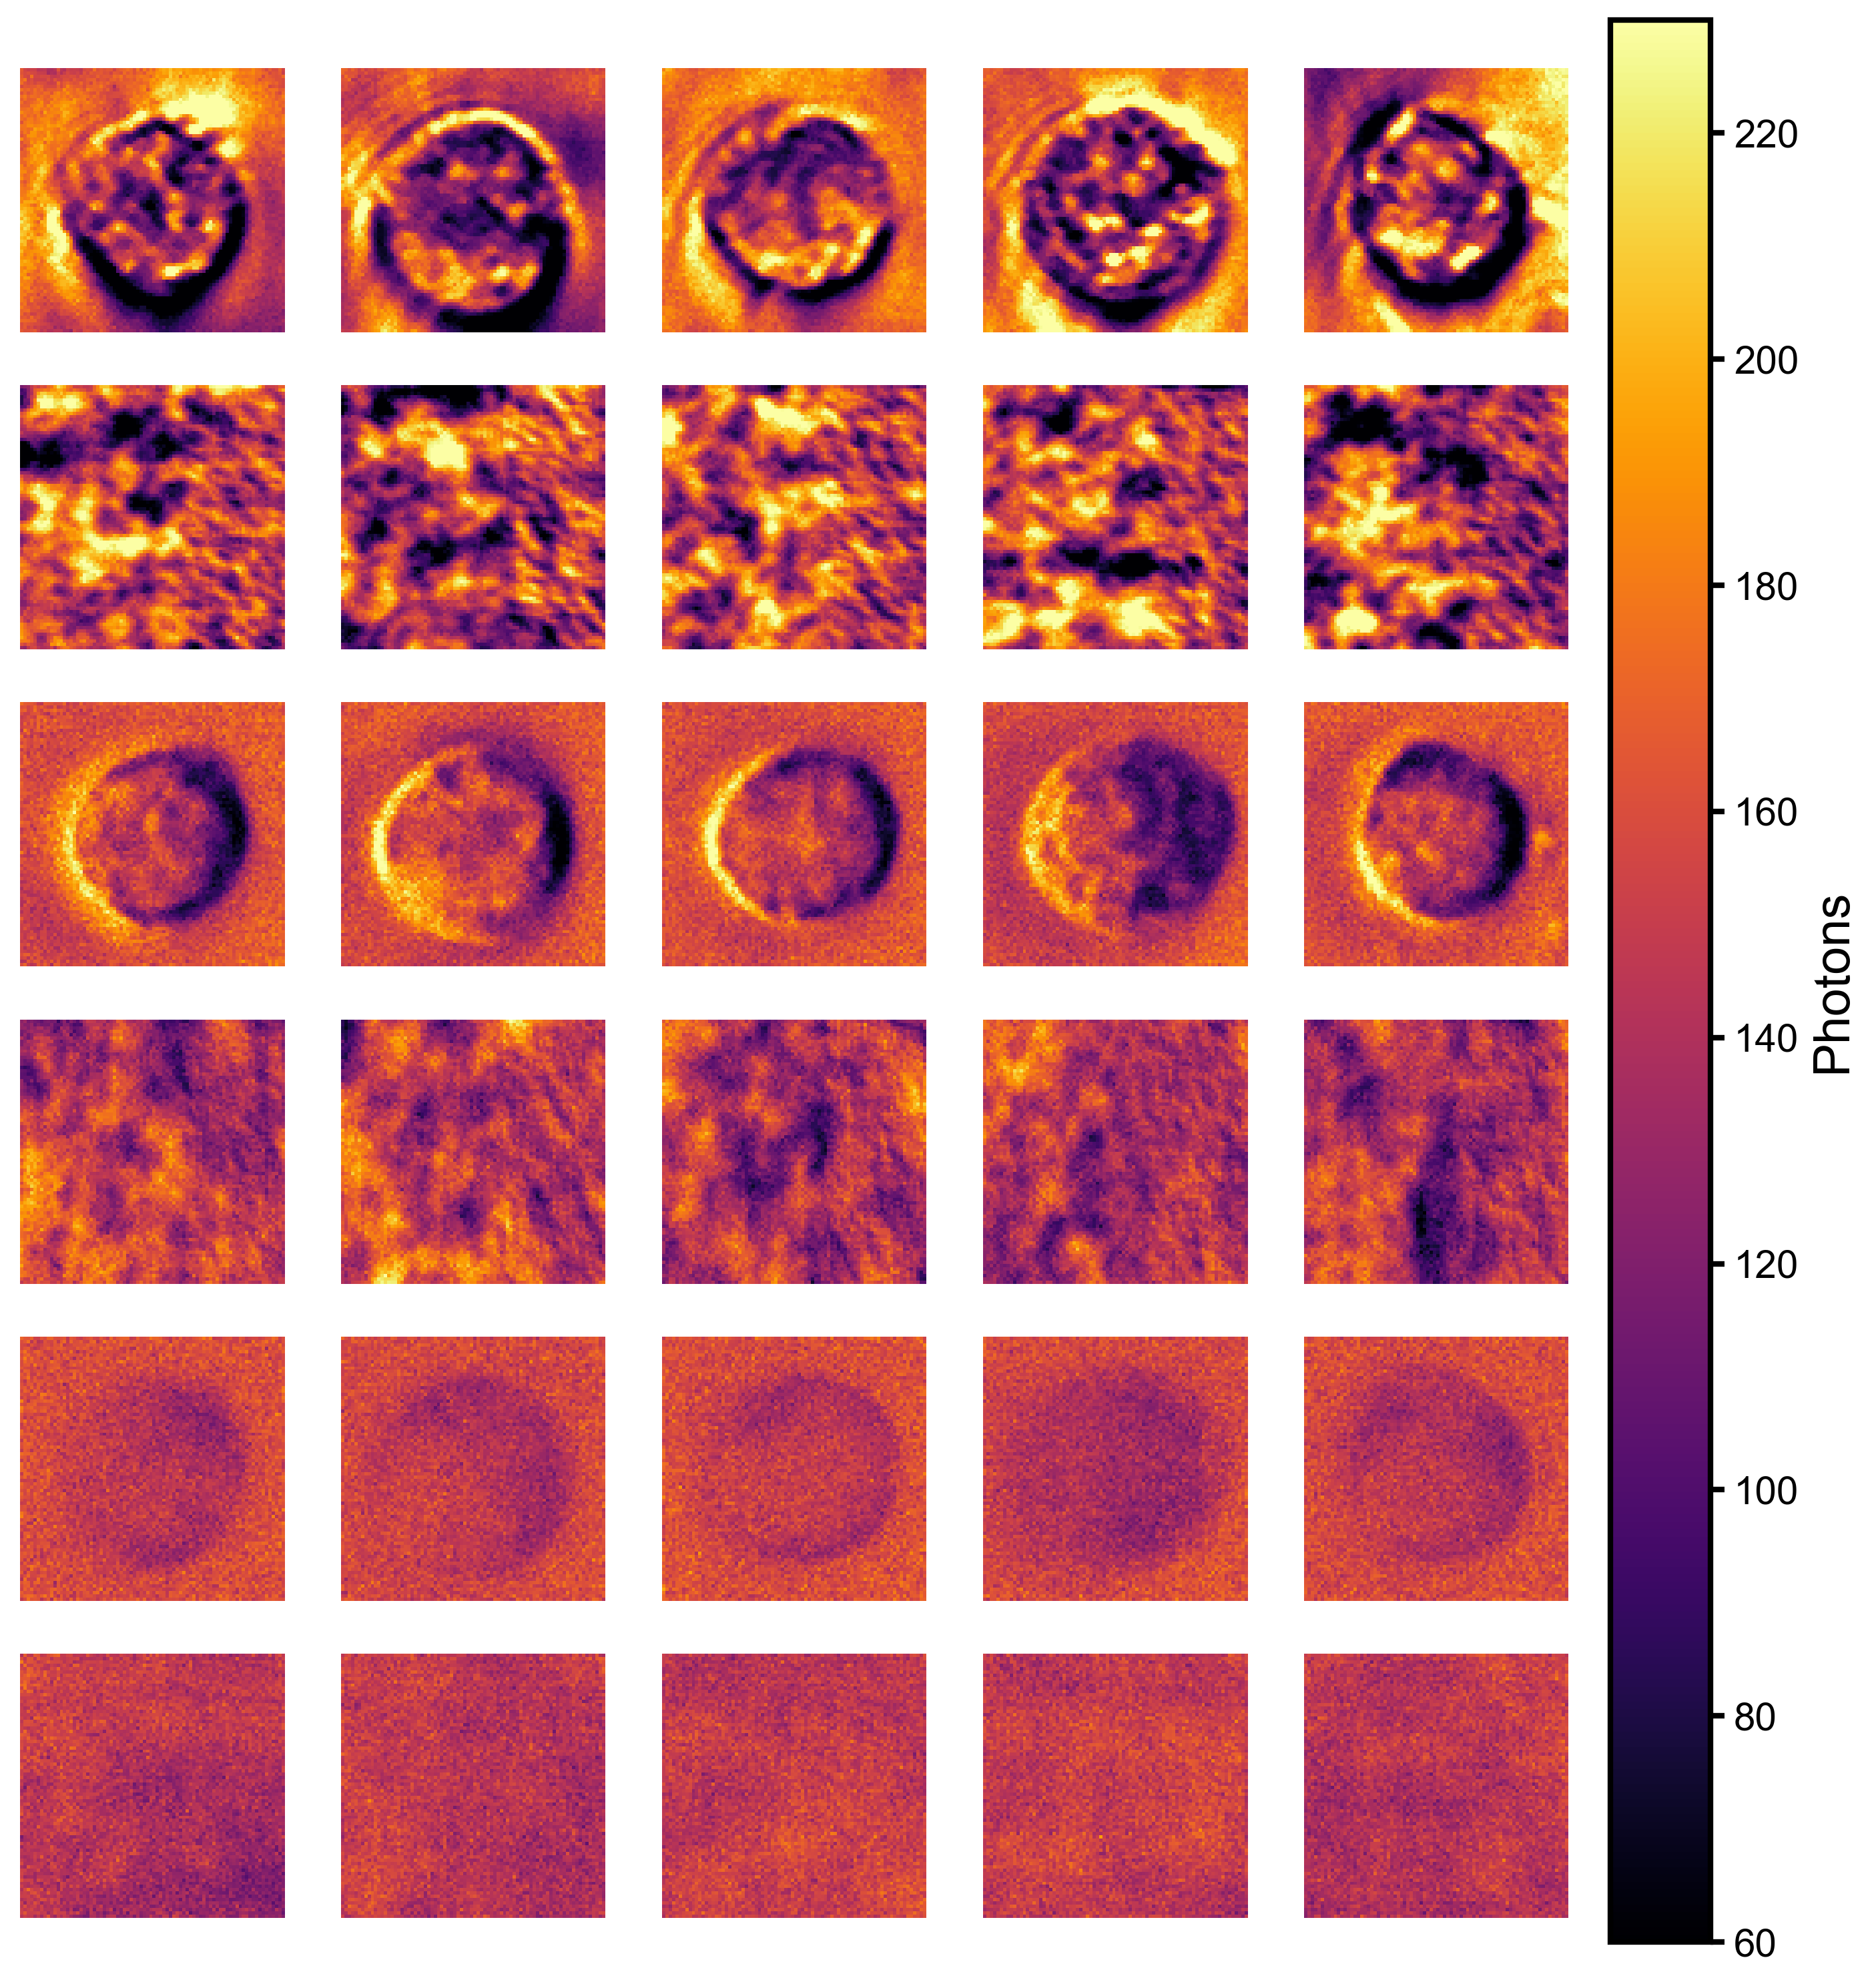

In [ ]:
image_samples = image_samples_gp

# take the min and max over all channels
# concatenate all pixels for all channels from both images and samples
# then take the min and max over all pixels
all_pix = onp.concatenate([onp.array(noisy_patches_by_channel[channel]) for channel in channels])
# vmin = np.percentile(all_pix, 1)
# vmax = np.percentile(all_pix, 99)
vmin, vmax = (60, 230)

fig, image_sample_ax = plt.subplots(len(channels) * 2, num_samples, 
                                figsize=(num_samples * 2, len(channels) * 2 * 2), dpi=300)
for channel_index, channel in enumerate(channels):
    # images = patches_by_channel[channel]
    images = images_by_channel[channel][[1, 3, 19, 5, 11]]
    noisy_images = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))
    samples = image_samples[channel]
    for i in range(num_samples):
        im = image_sample_ax[channel_index * 2, i].imshow(noisy_images[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2, i].axis('off')
        image_sample_ax[channel_index * 2 + 1, i].imshow(samples[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2 + 1, i].axis('off')
        

    image_sample_ax[channel_index*2, 0].set_ylabel(channel + '\n(images)')
    image_sample_ax[channel_index*2 + 1, 0].set_ylabel(channel + '\n(samples)')

# show one big colorbar on the right side spanning all rows
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.05, 0.8])
sm = cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm, cax=cbar_ax, label='Photons')

fig.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'intro_images_and_samples_gp' + '.pdf', transparent=True)

In [ ]:
image_samples = image_samples_pcnn

# take the min and max over all channels
# concatenate all pixels for all channels from both images and samples
# then take the min and max over all pixels
all_pix = onp.concatenate([onp.array(noisy_patches_by_channel[channel]) for channel in channels])
# vmin = np.percentile(all_pix, 1)
# vmax = np.percentile(all_pix, 99)
vmin, vmax = (60, 230)

fig, image_sample_ax = plt.subplots(len(channels) * 2, num_samples, 
                                figsize=(num_samples * 2, len(channels) * 2 * 2), dpi=300)
for channel_index, channel in enumerate(channels):
    # images = patches_by_channel[channel]
    images = images_by_channel[channel][[1, 3, 19, 5, 11]]
    noisy_images = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))
    samples = image_samples[channel]
    for i in range(num_samples):
        im = image_sample_ax[channel_index * 2, i].imshow(noisy_images[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2, i].axis('off')
        image_sample_ax[channel_index * 2 + 1, i].imshow(samples[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2 + 1, i].axis('off')
        

    image_sample_ax[channel_index*2, 0].set_ylabel(channel + '\n(images)')
    image_sample_ax[channel_index*2 + 1, 0].set_ylabel(channel + '\n(samples)')

# show one big colorbar on the right side spanning all rows
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.05, 0.8])
sm = cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm, cax=cbar_ax, label='Photons')

fig.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'intro_images_and_samples_pixel_cnn' + '.pdf', transparent=True)